### A/B Testing

A/B testing is a general methodology used when testing product changes and new features. We take two sets of users, the first set of users are given the changed product (experiment group) and the second set of users are given the original product (control group). We then compare the two groups to determine which version of the product is better.
A/B testing doesn’t work well when testing major changes, like new products.

Cookie Cats is a popular mobile puzzle game. As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress.
But where should the gates be placed?
Initially the first gate was placed at level 30. In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.

userid - a unique number that identifies each player.
version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
sum_gamerounds - the number of game rounds played by the player during the first week after installation
retention_1 - did the player come back and play 1 day after installing?
retention_7 - did the player come back and play 7 days after installing?
When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind

In [2]:
#import data
path = "C:/Users/marin_000/OneDrive/Kaggle/Projects/AB_testing/input/cookie_cats.csv"
raw_data = pd.read_csv(path)
df=raw_data.copy()

print("Number of rows: ", df.shape[0], " Number of columns: ", df.shape[1])
df.head()

Number of rows:  90189  Number of columns:  5


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


There is no missing values in our dataset.

In [4]:
df["version"].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

The number of players is roughly the same in the control and test group.

In [5]:
#Check how many duplicated users exist
print(df["userid"].count())
print(df["userid"].nunique())

90189
90189


In [6]:
#Summary Statistics
df.describe([0.01, 0.05, 0.10, 0.20, 0.50, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


In [7]:
df.groupby("sum_gamerounds")[["userid"]].count().reset_index().head(10)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


3994 users installed the game but never played the game.
More than 14000 players played fewer than three rounds of the game.

A boxplot can help to visualize if there are outliers in our dataset.

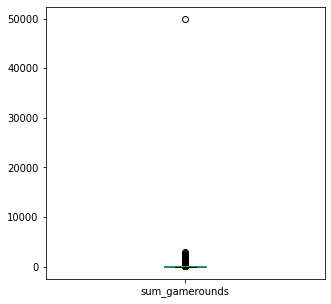

In [8]:
df['sum_gamerounds'].plot.box(figsize=(5,5))

We exclude this outlier.

In [9]:
df = df[df["sum_gamerounds"] < df["sum_gamerounds"].max()]

In [10]:
# A/B Groups and Summary Statistics
df.groupby("version").describe()[["sum_gamerounds"]]

sum_gamerounds                                                     
                 count       mean         std  min  25%   50%   75%     max
version                                                                    
gate_30        44699.0  51.342111  102.057598  0.0  5.0  17.0  50.0  2961.0
gate_40        45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0  2640.0

In [11]:
# Compare 1-day retention for each A/B Groups
df.groupby("version")["retention_1"].mean()

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

In [12]:
# Compare 7-day retention for each A/B Groups
df.groupby("version")["retention_7"].mean()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

There is a slight decrease in 1-day retention (from 44.8% to 44.2%) and 7-day retenion (from 19.0% to 18.2%) when the gate was moved to level 40 compared to the control when it was at level 30. We use bootstrap method to check if the difference in retention is statistically significant.  

#### Bootstrap method for analyzing 1-day retention for different groups

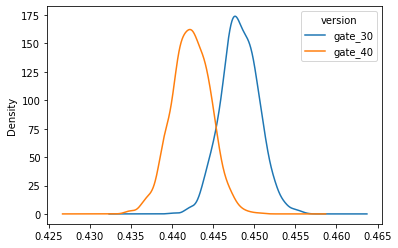

In [13]:
# Creating an list with bootstrapped means for each A/B-group
bootstrap_1d = []
for i in range(1000):
    bootstrap_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    bootstrap_1d.append(bootstrap_mean)
    
bootstrap_1d = pd.DataFrame(bootstrap_1d)
    
# density plot of the bootstrap distributions
bootstrap_1d.plot(kind='density')

Text(0.5, 1.0, 'Difference in 1-day retention between the two A/B-groups')

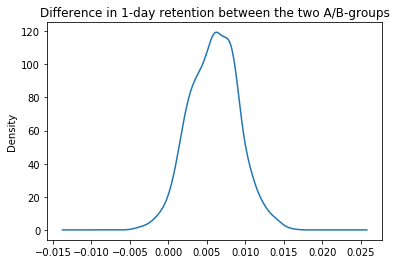

In [14]:
# H0: mean retention(gate_30) = mean retention(gate_40)
# HA: mean retention(gate_30) > mean retention(gate_40)

# Add a column with the difference between the two A/B-groups
bootstrap_1d['diff'] = bootstrap_1d["gate_30"] - bootstrap_1d["gate_40"]

# Ploting the bootstrap difference
bootstrap_1d['diff'].plot(kind='density')
plt.title('Difference in 1-day retention between the two A/B-groups')

In [15]:
# Calculating the p-value for our hypotheses
print('p-value:',1-(bootstrap_1d['diff'] > 0).mean())

p-value: 0.026000000000000023


At the significance level of 0.05 we reject the null hypothesis (1-day retention for the case when the gate is at level 30 is equal to 1-day retention for the case when the gate is at level 40) in favor of the alternative hypothesis (1-day retention for the case when the gate is at level 30 is greater then 1-day retention for the case when the gate is at level 40).  


#### Bootstrap method for analyzing 7-day retention for different groups

It makes sense to look at 7-day retention because it is likely that players who have been playing the game for 1 day have not reached the gate.

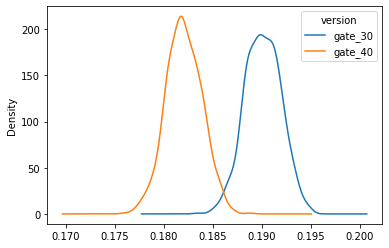

In [16]:
# Creating an list with bootstrapped means for each A/B-group
bootstrap_7d = []
for i in range(1000):
    bootstrap_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_7'].mean()
    bootstrap_7d.append(bootstrap_mean)
    
bootstrap_7d = pd.DataFrame(bootstrap_7d)
    
# density plot of the bootstrap distributions
bootstrap_7d.plot(kind='density')

Text(0.5, 1.0, 'Difference in 7-day retention between the two A/B-groups')

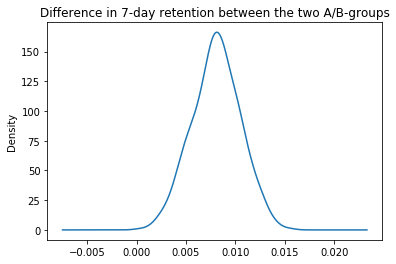

In [17]:
# H0: mean retention(gate_30) = mean retention(gate_40)
# HA: mean retention(gate_30) > mean retention(gate_40)

# Add a column with the difference between the two A/B-groups
bootstrap_7d['diff'] = bootstrap_7d["gate_30"] - bootstrap_7d["gate_40"]

# Ploting the bootstrap difference
bootstrap_7d['diff'].plot(kind='density')
plt.title('Difference in 7-day retention between the two A/B-groups')

In [18]:
# Calculating the p-value for our hypotheses
print('p-value:',1-(bootstrap_7d['diff'] > 0).mean())


p-value: 0.0


At the significance level of 0.05 we reject the null hypothesis (7-day retention for the case when the gate is at level 30 is equal to 7-day retention for the case when the gate is at level 40) in favor of the alternative hypothesis (7-day retention for the case when the gate is at level 30 is greater then 7-day retention for the case when the gate is at level 40).  

### Conclusion

Hypothesis testing with bootstrap method tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40, we should not move the gate from level 30 to level 40.